## Import Dependencies

In [30]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, RepeatVector, Concatenate, Bidirectional, LSTM,Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers


## Import Dataset

In [3]:
url = 'https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk'
gdown.download(url, 'weather.csv', quiet=False)
df = pd.read_csv('weather.csv')


Downloading...
From (original): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk
From (redirected): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk&confirm=t&uuid=9fe0c276-fc34-4acd-99ef-e780a6a16ca6
To: d:\KULI\SEM 6\DBS\Capstone\Predict weather\weather.csv
100%|██████████| 132M/132M [00:22<00:00, 5.89MB/s] 


In [4]:
df.head(5)

,datetime,datetimeepoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,description,icon,stations,source,kecamatan,severerisk,day,month,weekday,year
0,2020-01-01,1577811600,31.1,20.6,24.8,36.9,20.6,26.0,22.0,85.6,...,partly cloudy throughout the day with rain in ...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,1,1,2,2020
1,2020-01-02,1577898000,33.2,19.2,24.7,39.3,19.2,25.8,21.2,82.5,...,partly cloudy throughout the day with late aft...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,2,1,3,2020
2,2020-01-03,1577984400,31.7,20.8,24.4,39.6,20.8,25.5,22.3,88.7,...,partly cloudy throughout the day with late aft...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,3,1,4,2020
3,2020-01-04,1578070800,31.2,20.4,24.4,39.1,20.4,25.5,22.0,87.3,...,partly cloudy throughout the day with afternoo...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,4,1,5,2020
4,2020-01-05,1578157200,31.2,20.6,25.0,37.4,20.6,26.2,22.0,84.7,...,partly cloudy throughout the day with early mo...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,5,1,6,2020


## Feature Engineering

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [6]:
if 'kecamatan' in df.columns:
  df['pressure_diff'] = df.groupby('kecamatan')['pressure'].diff()

else:
  df['pressure_diff'] = df['pressure'].diff().fillna(0)

df['dew_point_spread'] = df['temp'] - df['dew']


In [7]:
LAG_PERIOD = 1
if 'kecamatan' in df.columns:
  df[f'humidity_lag{LAG_PERIOD}'] = df.groupby('kecamatan')['humidity'].shift(LAG_PERIOD)
  df[f'humidity_lag{LAG_PERIOD}'] = df[f'humidity_lag{LAG_PERIOD}'].fillna(df['humidity'].median())
else:
  df[f'humidity_lag{LAG_PERIOD}'] = df['humidity'].shift(LAG_PERIOD)
  df[f'humidity_lag{LAG_PERIOD}'] = df[f'humidity_lag{LAG_PERIOD}'].fillna(df['humidity'].median())

## Preprocessing

In [8]:
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [9]:
df.isna().sum()

datetime            0
datetimeepoch       0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
pressure            0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
sunrise             0
sunriseepoch        0
sunset              0
sunsetepoch         0
moonphase           0
conditions          0
description         0
icon                0
stations            0
source              0
kecamatan           0
severerisk          0
day                 0
month               0
weekday             0
year                0
pressure_diff       0
dew_point_spread    0
humidity_lag1       0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
targets = ['precipprob', 'windspeed', 'temp', 'humidity']

In [12]:
non_numerical_cols_to_remove = ['datetime', 'kecamatan', 'sunrise', 'sunset', 'conditions', 'icon', 'description', 'stations', 'source']

features = [
    col for col in df.select_dtypes(include=['int64', 'float64']).columns
    if col not in non_numerical_cols_to_remove and col not in targets and col != 'kecamatan_encoded'
]

date_features = ['year', 'month', 'day', 'weekday', 'pressure_diff', 'dew_point_spread', f'humidity_lag{LAG_PERIOD}']

features

['datetimeepoch',
 'tempmax',
 'tempmin',
 'feelslikemax',
 'feelslikemin',
 'feelslike',
 'dew',
 'precip',
 'precipcover',
 'snow',
 'snowdepth',
 'windgust',
 'winddir',
 'pressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'sunriseepoch',
 'sunsetepoch',
 'moonphase',
 'severerisk',
 'pressure_diff',
 'dew_point_spread',
 'humidity_lag1']

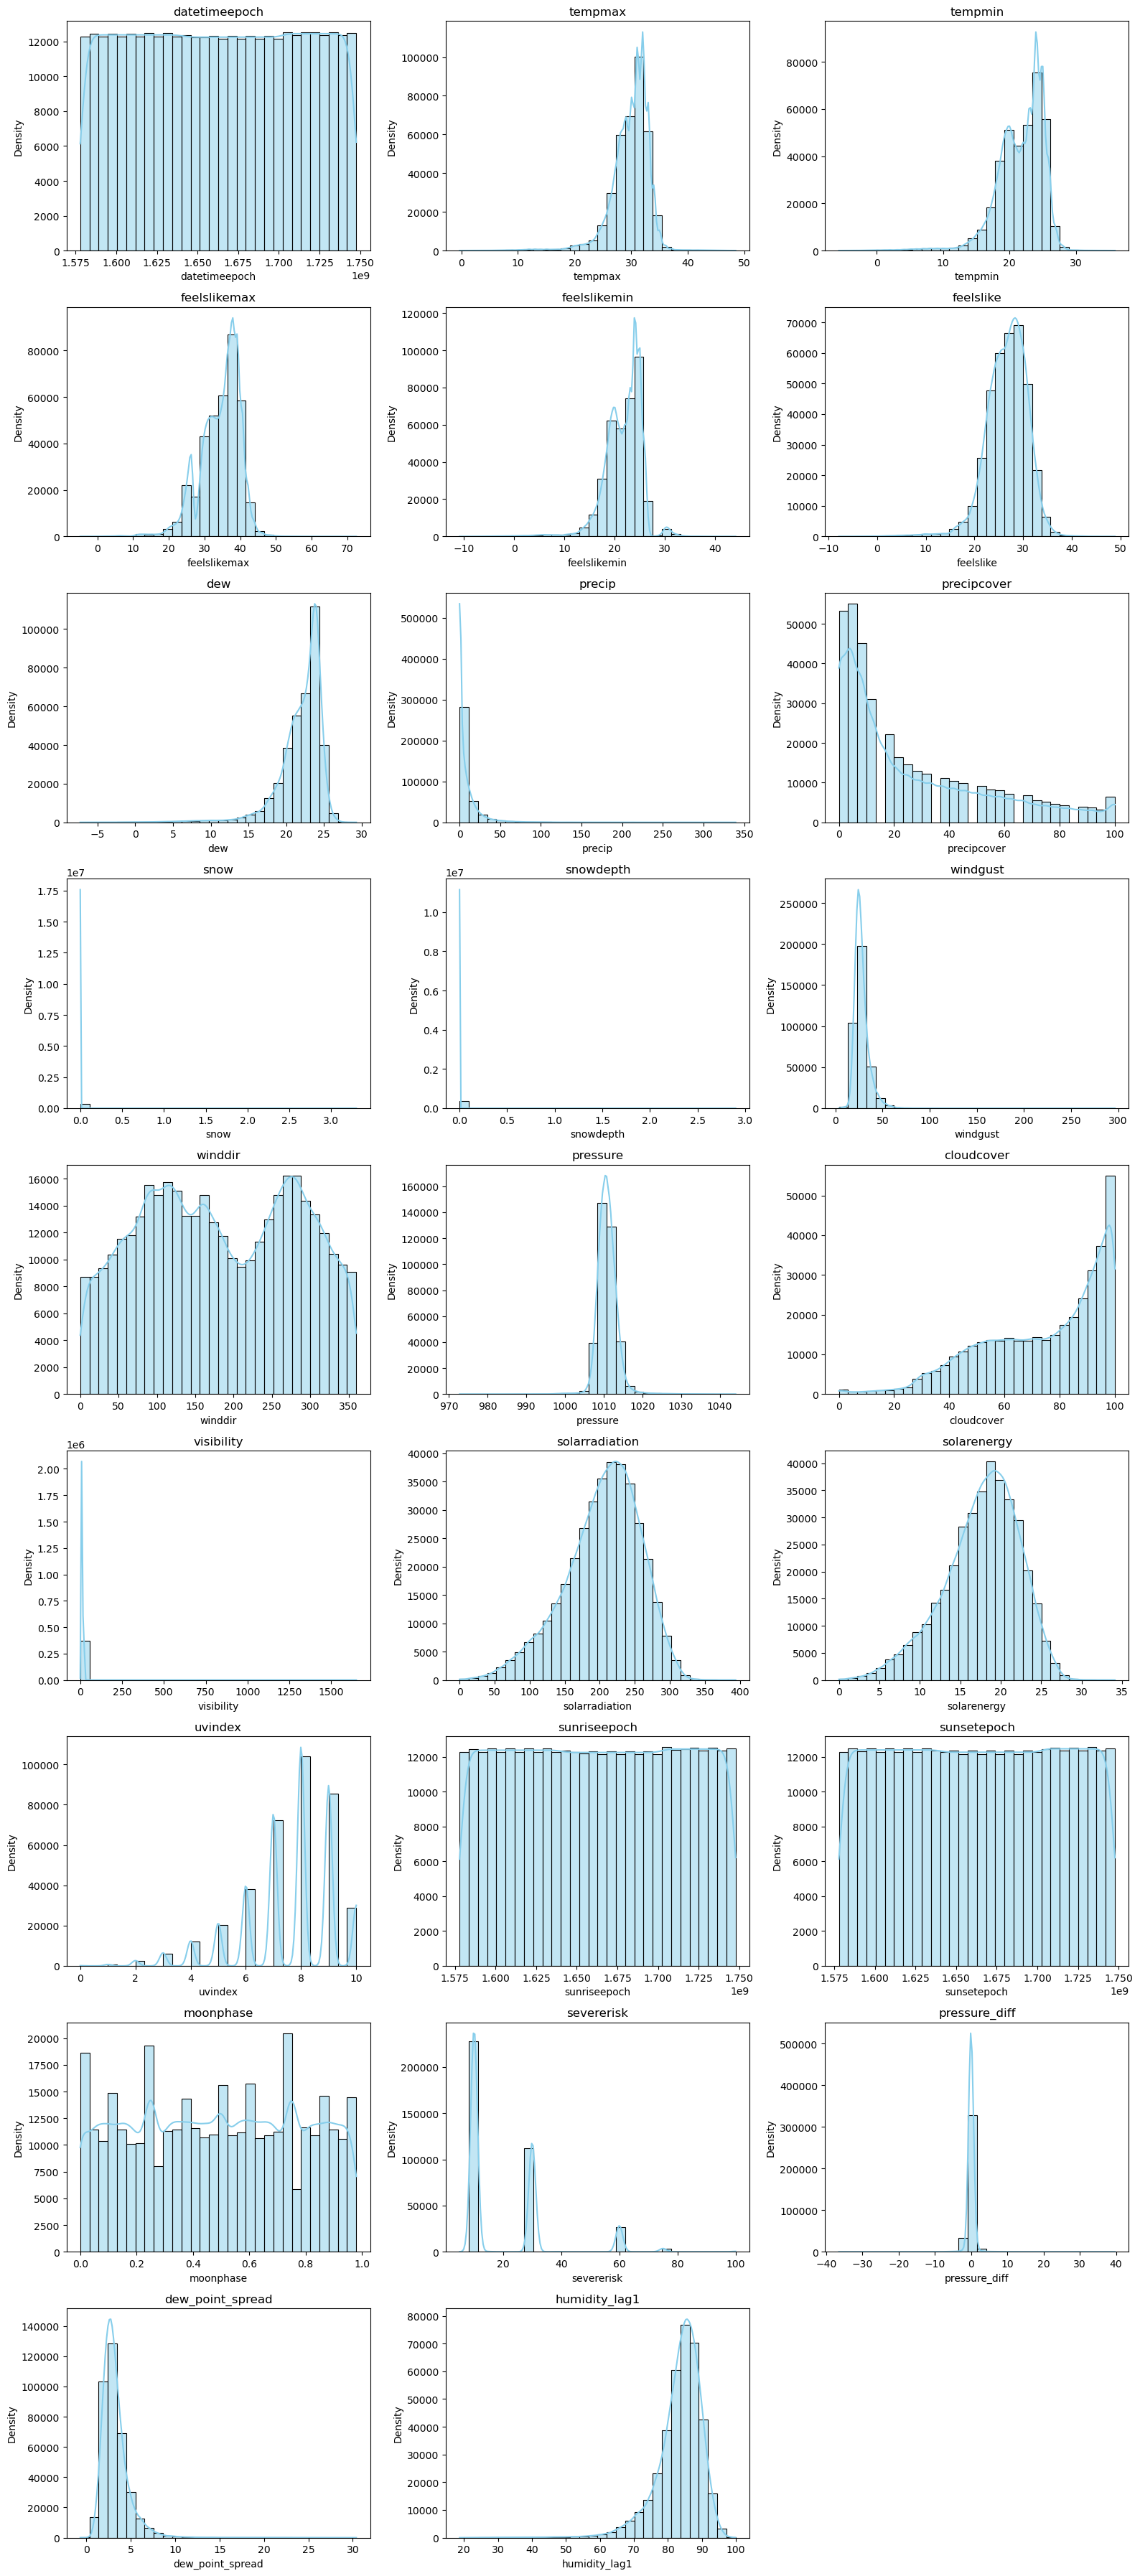

In [13]:
visualise = features

n_cols = 3
n_rows = (len(visualise) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(visualise):
  ax = axes[i]
  sns.histplot(df[col], bins=30, kde=True, ax=ax, color='skyblue')
  ax.set_title(f'{col}')
  ax.set_xlabel(col)
  ax.set_ylabel('Density')

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [14]:
label_encoder = LabelEncoder()
df['kecamatan_encoded'] = label_encoder.fit_transform(df['kecamatan'])
X_cat = df['kecamatan_encoded'].values.reshape(-1, 1)

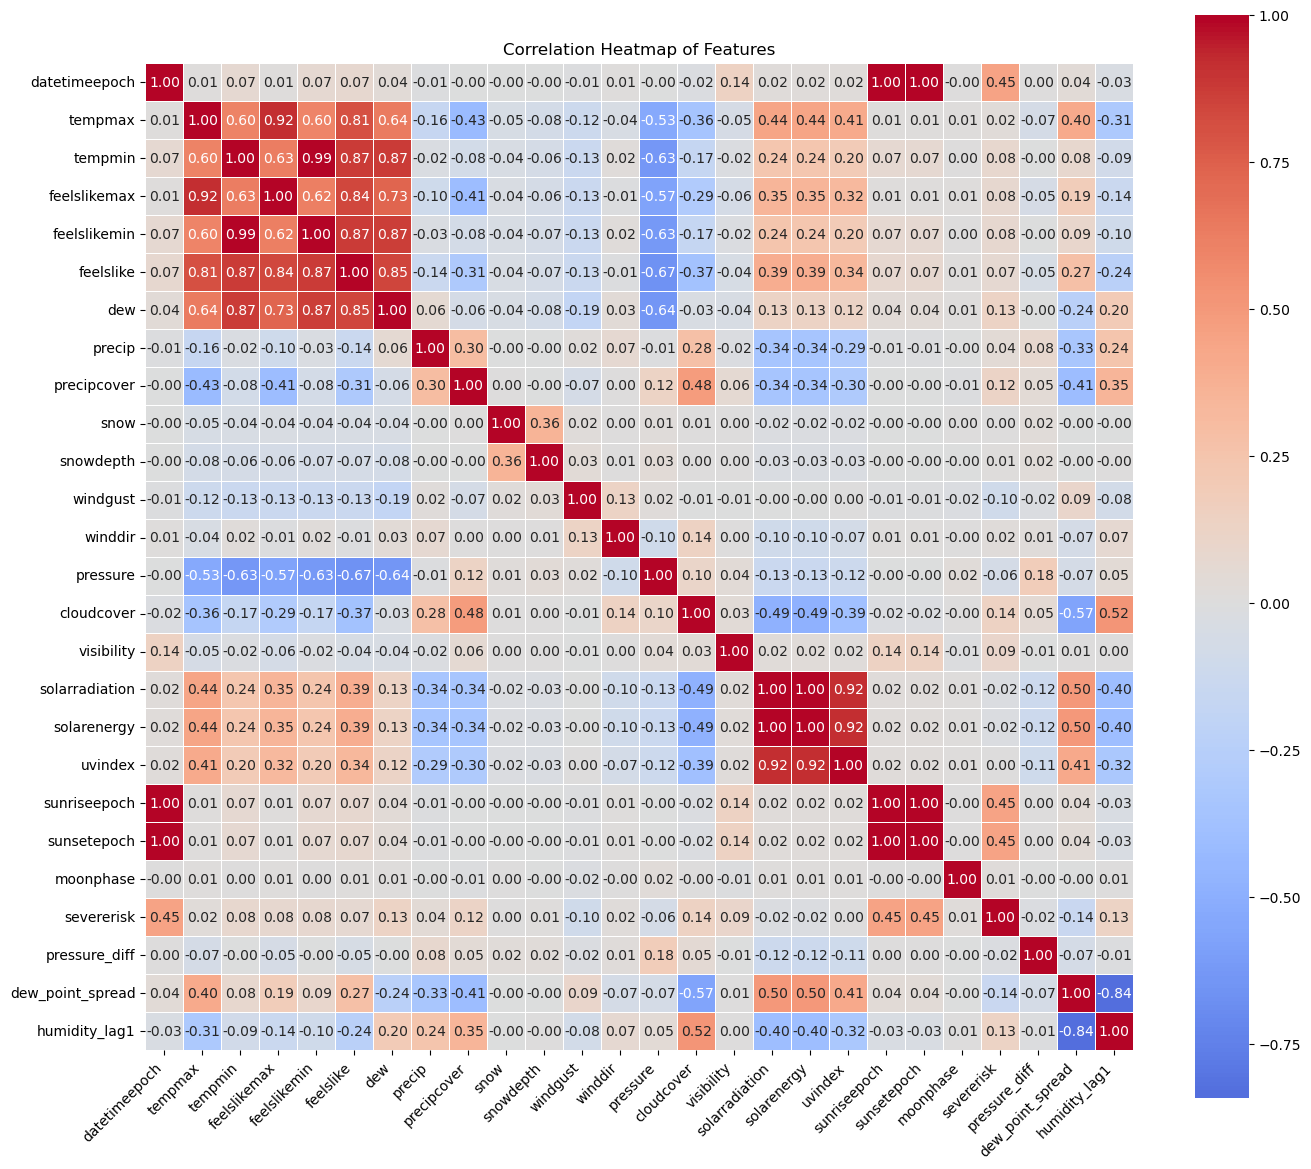

In [15]:
features_numeric = [col for col in features if pd.api.types.is_numeric_dtype(df[col])]

corr_matrix = df[features_numeric].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
non_numeric_cols = ['stations', 'source']
numeric_features = [col for col in features if col not in non_numeric_cols]

X_num = df[numeric_features].values

y = df[targets].values

In [17]:
feature_scaler = RobustScaler()
target_scaler = RobustScaler()
X_num_scaled = feature_scaler.fit_transform(X_num)
y_scaled = target_scaler.fit_transform(y)

## Split Data

In [18]:
def create_sequences(X_num, X_cat, y, time_steps=7):
  Xs_num, Xs_cat, ys = [], [], []
  for i in range(len(X_num) - time_steps):
    Xs_num.append(X_num[i:i+time_steps])
    Xs_cat.append(X_cat[i+time_steps])
    ys.append(y[i+time_steps])
  return np.array(Xs_num), np.array(Xs_cat), np.array(ys)

TIME_STEPS = 7
X_seq_num, X_seq_cat, y_seq = create_sequences(X_num_scaled, X_cat, y_scaled, TIME_STEPS)

In [19]:
dates = df['datetime'].values[TIME_STEPS:]
train_idx = [i for i, d in enumerate(dates) if pd.to_datetime(d).year <= 2023]
test_idx = [i for i, d in enumerate(dates) if pd.to_datetime(d).year > 2023]

In [20]:
X_train_num, X_train_cat, y_train = X_seq_num[train_idx], X_seq_cat[train_idx], y_seq[train_idx]
X_test_num, X_test_cat, y_test = X_seq_num[test_idx], X_seq_cat[test_idx], y_seq[test_idx]


## Model Building

In [21]:
n_features = X_train_num.shape[2]
n_kecamatan = df['kecamatan_encoded'].nunique()

input_num = Input(shape=(TIME_STEPS, n_features), name='numerical_input')
input_cat = Input(shape=(1,), name='kecamatan_input')

l2_lambda = 0.001

embedding_dim = 8
embedded_cat = Embedding(input_dim=n_kecamatan, output_dim=embedding_dim)(input_cat)
embedded_cat_flat = Flatten()(embedded_cat)
repeated_cat = RepeatVector(TIME_STEPS)(embedded_cat_flat)

combined = Concatenate()([input_num, repeated_cat])

x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_lambda)))(combined)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(l2_lambda)))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
output = Dense(len(targets))(x)

model = Model(inputs=[input_num, input_cat], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ kecamatan_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │      1,568 │ kecamatan_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 7, 26)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 8)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 34)     │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 128)    │     50,688 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 128)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        132 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,684 (373.77 KB)

 Trainable params: 95,684 (373.77 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
  [X_train_num, X_train_cat], y_train,
  validation_split=0.2,
  epochs=50,                  # More epochs, rely on early stopping
  batch_size=32,              # Smaller batch size may help generalization
  callbacks=[early_stop],
  verbose=1
)

Epoch 1/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - loss: 189.9991 - mean_absolute_error: 3.9943 - val_loss: 229.3992 - val_mean_absolute_error: 4.6337
Epoch 2/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 173.1494 - mean_absolute_error: 3.7477 - val_loss: 216.9511 - val_mean_absolute_error: 4.4497
Epoch 3/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 171.5025 - mean_absolute_error: 3.6997 - val_loss: 214.8036 - val_mean_absolute_error: 4.1596
Epoch 4/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - loss: 165.5240 - mean_absolute_error: 3.5777 - val_loss: 213.1564 - val_mean_absolute_error: 4.3011
Epoch 5/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - loss: 160.0177 - mean_absolute_error: 3.4721 - val_loss: 213.5681 - val_mean_absolute_error: 4.1762
Epoch 6/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 153.9576 - mean_absolute_error: 3.3487 - val_loss: 215.7179 - val_mean_absolute_error: 4.2344
Epoch 7/50
6862/6862 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - l

## Model Evaluation

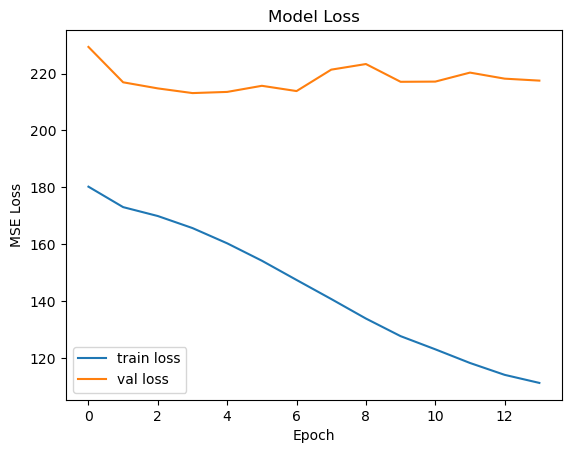

In [23]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [24]:
y_pred_scaled = model.predict([X_test_num, X_test_cat])
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

metrics = {}
for i, target_name in enumerate(targets):
  mse = mean_squared_error(y_true[:, i], y_pred[:, i])
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
  r2 = r2_score(y_true[:, i], y_pred[:, i])
  metrics[target_name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

for target_name, vals in metrics.items():
  print(f"Metrics for {target_name}:")
  print(f"  MSE: {vals['MSE']:.4f}")
  print(f"  RMSE: {vals['RMSE']:.4f}")
  print(f"  MAE: {vals['MAE']:.4f}")
  print(f"  R2: {vals['R2']:.4f}")
  print()

3005/3005 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Metrics for precipprob:
  MSE: 982.4110
  RMSE: 31.3434
  MAE: 17.6959
  R2: 0.3141

Metrics for windspeed:
  MSE: 41.1635
  RMSE: 6.4159
  MAE: 4.9285
  R2: 0.2529

Metrics for temp:
  MSE: 2.6224
  RMSE: 1.6194
  MAE: 1.0586
  R2: 0.7445

Metrics for humidity:
  MSE: 23.6677
  RMSE: 4.8649
  MAE: 3.5177
  R2: 0.5571



In [25]:
def forecast_from_date(model, data, kecamatan_name, start_date, features, targets, feature_scaler, target_scaler, label_encoder, time_steps=7, forecast_days=7):
  start_date_dt = pd.to_datetime(start_date)

  # Filter and sort data for the selected kecamatan
  kecamatan_data = data[data['kecamatan'] == kecamatan_name].sort_values('datetime').reset_index(drop=True)

  # Find data up to the day before the start_date for history
  historical_data_for_init = kecamatan_data[kecamatan_data['datetime'] < start_date_dt]
  if len(historical_data_for_init) < time_steps:
      raise ValueError(f"Not enough historical data before {start_date_dt.date()} for kecamatan '{kecamatan_name}'. "
                       f"Need {time_steps} days, got {len(historical_data_for_init)} days.")


  current_sequence_unscaled_df = historical_data_for_init.tail(time_steps).copy()

  # Encode categorical kecamatan (once, as it's constant for the forecast period for this kecamatan)
  try:
      kecamatan_encoded_val = label_encoder.transform([kecamatan_name])[0]
  except ValueError:
      raise ValueError(f"Kecamatan '{kecamatan_name}' not seen during training. Cannot encode.")
  X_cat_pred = np.array([[kecamatan_encoded_val]])

  # Store the actual predicted target values (unscaled)
  forecast_outputs_list = []


  for i in range(forecast_days):
      # Ensure that the columns extracted match exactly what feature_scaler expects, in the correct order.
      X_num_unscaled_for_pred = current_sequence_unscaled_df[features].values

      X_num_scaled_for_pred = feature_scaler.transform(X_num_unscaled_for_pred)
      X_seq_reshaped = X_num_scaled_for_pred.reshape((1, time_steps, len(features)))

      # Predict scaled targets
      pred_scaled = model.predict([X_seq_reshaped, X_cat_pred], verbose=0)[0]

      # Inverse transform to get actual target values
      pred_unscaled_targets_array = target_scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]
      pred_unscaled_targets_dict = dict(zip(targets, pred_unscaled_targets_array))
      forecast_outputs_list.append(pred_unscaled_targets_array)

      # Prepare the feature row for the NEXT day's prediction
      if i == forecast_days - 1: # No need to prepare input for next step if this is the last forecast day
        break

      last_known_unscaled_row = current_sequence_unscaled_df.iloc[-1]
      next_forecast_datetime = current_sequence_unscaled_df['datetime'].iloc[-1] + pd.Timedelta(days=1)
      new_row_unscaled_dict = {}

      # Date features
      new_row_unscaled_dict['year'] = next_forecast_datetime.year
      new_row_unscaled_dict['month'] = next_forecast_datetime.month
      new_row_unscaled_dict['day'] = next_forecast_datetime.day
      new_row_unscaled_dict['weekday'] = next_forecast_datetime.weekday()

      # Target-derived/updated features for the *new row* based on *current predictions*
      if 'humidity_lag1' in features:
        new_row_unscaled_dict['humidity_lag1'] = pred_unscaled_targets_dict['humidity']

      carried_forward_dew = last_known_unscaled_row['dew'] if 'dew' in features else 0.0
      if 'dew' in features:
        new_row_unscaled_dict['dew'] = carried_forward_dew

      if 'dew_point_spread' in features:
        new_row_unscaled_dict['dew_point_spread'] = pred_unscaled_targets_dict['temp'] - carried_forward_dew


      carried_forward_pressure = last_known_unscaled_row['pressure'] if 'pressure' in features else 0.0
      if 'pressure' in features:
        new_row_unscaled_dict['pressure'] = carried_forward_pressure
      if 'pressure_diff' in features:
        new_row_unscaled_dict['pressure_diff'] = carried_forward_pressure - last_known_unscaled_row['pressure']

      for feat_name in features:
        if feat_name not in new_row_unscaled_dict:
          if feat_name in last_known_unscaled_row:
            new_row_unscaled_dict[feat_name] = last_known_unscaled_row[feat_name]
          else:
            new_row_unscaled_dict[feat_name] = 0.0

      new_row_df = pd.DataFrame([new_row_unscaled_dict])
      new_row_df['datetime'] = next_forecast_datetime
      new_row_df['kecamatan'] = kecamatan_name
      current_sequence_unscaled_df = pd.concat([current_sequence_unscaled_df.iloc[1:], new_row_df], ignore_index=True)

  forecast_actual_values = np.array(forecast_outputs_list)
  forecast_df = pd.DataFrame(forecast_actual_values, columns=targets)

  forecast_dates = [start_date_dt + pd.Timedelta(days=i) for i in range(forecast_days)]
  forecast_df['datetime'] = forecast_dates[:len(forecast_df)]
  forecast_df['kecamatan'] = kecamatan_name
  return forecast_df[['datetime', 'kecamatan'] + targets]

In [26]:
start_date = '2025-01-29'
kecamatan_name = 'trikora'


TIME_STEPS_FOR_FORECAST = TIME_STEPS # Which is 7 from your training setup

forecast_df = forecast_from_date(
  model=model,
  data=df,
  kecamatan_name=kecamatan_name,
  start_date=start_date,
  features=features,
  targets=targets,
  feature_scaler=feature_scaler,
  target_scaler=target_scaler,
  label_encoder=label_encoder,
  time_steps=TIME_STEPS_FOR_FORECAST,
  forecast_days=7
)

print(forecast_df)


    datetime kecamatan  precipprob  windspeed       temp   humidity
0 2025-01-29   trikora   99.113312  13.602465  26.490997  85.352356
1 2025-01-30   trikora   99.451454  12.826787  26.338453  86.402901
2 2025-01-31   trikora   99.530182  12.173490  26.308725  86.747635
3 2025-02-01   trikora   99.513863  11.914985  26.346308  86.930382
4 2025-02-02   trikora   99.547607  12.210917  26.372095  86.683540
5 2025-02-03   trikora   99.502472  11.487142  26.356510  87.048111
6 2025-02-04   trikora   99.543190  10.814482  26.306496  87.309189


## Save Model

In [31]:
preprocessor_save_path = 'weather_preprocessors.pkl'
features_list_save_path = 'weather_feature_list.pkl'

with open(preprocessor_save_path, 'wb') as f:
    pickle.dump({
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'label_encoder': label_encoder
    }, f)
print(f"Preprocessors saved to {preprocessor_save_path}")

with open(features_list_save_path, 'wb') as f:
    pickle.dump(features, f) 
print(f"Feature list saved to {features_list_save_path}")

Preprocessors saved to weather_preprocessors.pkl
Feature list saved to weather_feature_list.pkl


In [27]:
keras_model_save_path = 'weather_prediction_lstm_model.keras'
model.save(keras_model_save_path)
print(f"Model saved to {keras_model_save_path}")

Model saved to weather_prediction_lstm_model.keras


In [28]:
model.export('weather_prediction_lstm_model/')

INFO:tensorflow:Assets written to: weather_prediction_lstm_model/assets


INFO:tensorflow:Assets written to: weather_prediction_lstm_model/assets


Saved artifact at 'weather_prediction_lstm_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 7, 26), dtype=tf.float32, name='numerical_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='kecamatan_input')]
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1965024438864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024439632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024440592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024443088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024442512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024440976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024441744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024442320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024443472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1965024442704:

In [29]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    '/content/model_conversion/saved_model' \
    '/content/tfjs_model'

'tensorflowjs_converter' is not recognized as an internal or external command,
operable program or batch file.
